# The Power of Autoencoders: Non-Linear Dimension Reduction

In the world of data, we often face the "curse of dimensionality"—datasets with hundreds or even thousands of features. High-dimensional data is difficult to visualize, slow to process, and can make machine learning models perform poorly.

**Dimension reduction** is the art of transforming data from a high-dimensional space into a meaningful, low-dimensional representation. While classic methods like Principal Component Analysis (PCA) are powerful, they are limited to finding **linear** relationships.

The groundbreaking 2006 paper, "Reducing the Dimensionality of Data with Neural Networks," G.E. Hinton and R.R. Salakhutdinov, showed how a deep neural network called an **autoencoder** could learn a powerful, **non-linear** compression of data.

This tutorial will walk you through the intuition, implementation, and modern applications of this elegant idea by introducing:
  * What an autoencoder is and how it works
  * Why autoencoders can be seen as a non-linear generalization of PCA
  * How to build and train a deep autoencoder using TensorFlow/Keras on the MNIST handwritten digit dataset
  * How to visualize the low-dimensional "codes" and see the learned structure
  * How this core concept of dimension reduction powers modern AI like **Vector Search** and **Retrieval-Augmented Generation (RAG)**

**Credits**

This notebook is adapted from Hinton, G. E., & Salakhutdinov, R. R. (2006). Reducing the dimensionality of data with neural networks. science, 313(5786), 504-507. <https://www.cs.toronto.edu/~hinton/absps/science.pdf>


**Compatibility**

| Platform | Compatibility | Recommended | Notes |
| :--- | :--- | :--- | :--- |
| **Local Machine** (e.g., 16GB RAM Laptop) | ✅ Yes | ✅ Yes | The MNIST dataset is small, and training is fast on a modern CPU. |
| **Google Colab** | ✅ Yes | ✅ Yes | **Recommended.** Provides a free, pre-configured environment with GPU access, which significantly accelerates model training. |
| **Midway3 Login Node** | ✅ Yes | ❌ No | **Not recommended.** Avoid running computation-intensive jobs on the login nodes. |
| **Midway3 Compute Node** | ✅ Yes | ✅ Yes | Ideal for running on the compute nodes. |

-----

## 1\. What is an Autoencoder?

An autoencoder is a type of neural network trained to reconstruct its own input. It sounds trivial, but the magic happens in the middle. The network is designed with an "hourglass" shape, featuring a narrow central layer called the **bottleneck** or **code** layer.

The architecture has two main parts:

1.  **The Encoder:** This part of the network takes the high-dimensional input data and compresses it down into a dense, low-dimensional representation (the "code").
2.  **The Decoder:** This part takes the compressed code and tries to reconstruct the original high-dimensional input from it.

The network is trained by minimizing the **reconstruction error**—the difference between the original input and the reconstructed output. By forcing the data through the narrow bottleneck, the network must learn the most important, salient features of the data to create a code that allows for good reconstruction.

This compressed code is the powerful, low-dimensional embedding we're looking for.

## 2\. Hands-On: Building a Deep Autoencoder with PyTorch

Let's build an autoencoder to compress the 784-pixel MNIST handwritten digits into a tiny **2-dimensional** vector. This will allow us to visualize the learned structure in a 2D plot.

### **Step 1: Setup and Data Loading**

We'll use PyTorch and the `torchvision` library, which provides easy access to datasets like MNIST.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define a transform to normalize the data
transform = transforms.ToTensor()

# Download and load the training data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 60.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.71MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.3MB/s]


### **Step 2: Define the Autoencoder Architecture**

We'll create a deep autoencoder. The encoder will progressively reduce the dimensions from 784 down to 2, and the decoder will symmetrically expand it back to 784.

In PyTorch, we define models by creating a class that inherits from `nn.Module`. We'll use `nn.Sequential` to neatly define our encoder and decoder stacks.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, original_dim, latent_dim):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(original_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim) # Bottleneck
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, original_dim),
            nn.Sigmoid() # Output layer uses sigmoid for pixel probabilities [0,1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# --- Instantiate the Model ---
original_dim = 784
latent_dim = 2
model = Autoencoder(original_dim, latent_dim)
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


### **Step 3: Train the Model**

We'll define our loss function and optimizer, then write a standard PyTorch training loop.

Notice that the input and target output are the same data (`img` from the `train_loader`).

In [ ]:
# --- Define Loss and Optimizer ---
criterion = nn.BCELoss() # Binary Cross-Entropy for reconstruction
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 5

# --- Training Loop ---
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data # We don't need the labels
        # Flatten the images
        img = img.view(img.size(0), -1)

        # Forward pass
        output = model(img)
        loss = criterion(output, img) # Compare reconstruction to original

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 0.1901
Epoch [2/5], Loss: 0.1784
Epoch [3/5], Loss: 0.1790
Epoch [4/5], Loss: 0.1764
Epoch [5/5], Loss: 0.1703


### **Step 4: Visualize the Results**

Now for the exciting part. Let's see what the autoencoder learned.

#### **A. Visualizing the Latent Space**

We'll pass the test data through the encoder part of our model to get the 2D codes and plot them. We'll color each point according to its true digit label.

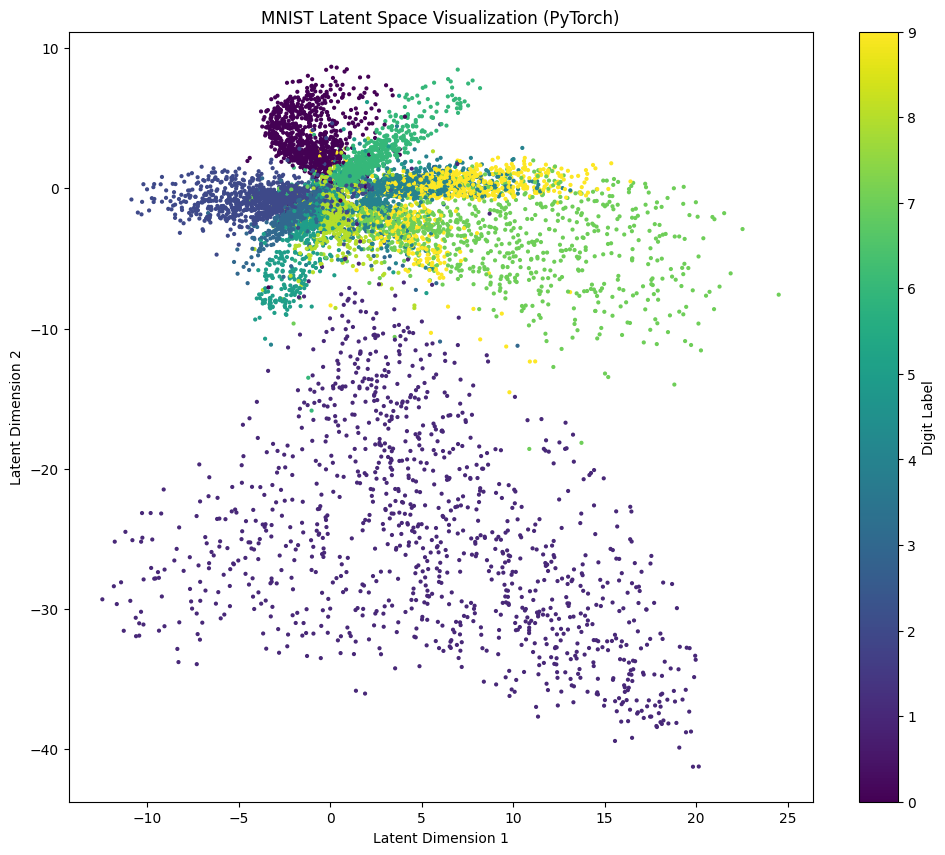

In [ ]:
# Set model to evaluation mode
model.eval()

latent_codes = []
labels = []

# Use no_grad to disable gradient calculations for inference
with torch.no_grad():
    for data in test_loader:
        img, label_batch = data
        img = img.view(img.size(0), -1)

        # Get the latent code
        encoded = model.encoder(img)

        latent_codes.append(encoded.numpy())
        labels.append(label_batch.numpy())

# Concatenate all batches
latent_codes = np.concatenate(latent_codes, axis=0)
labels = np.concatenate(labels, axis=0)

# Plot the latent space
plt.figure(figsize=(12, 10))
plt.scatter(latent_codes[:, 0], latent_codes[:, 1], c=labels, cmap='viridis', s=4)
plt.colorbar(label='Digit Label')
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("MNIST Latent Space Visualization (PyTorch)")
plt.show()

You should see something remarkable: the network, without ever being told about digit labels, has learned to group similar digits together in the 2D latent space. This demonstrates that it has discovered the underlying non-linear structure of the data.

#### **B. Visualizing Reconstructions**

Finally, let's see how well the model can reconstruct images from their 2D codes.

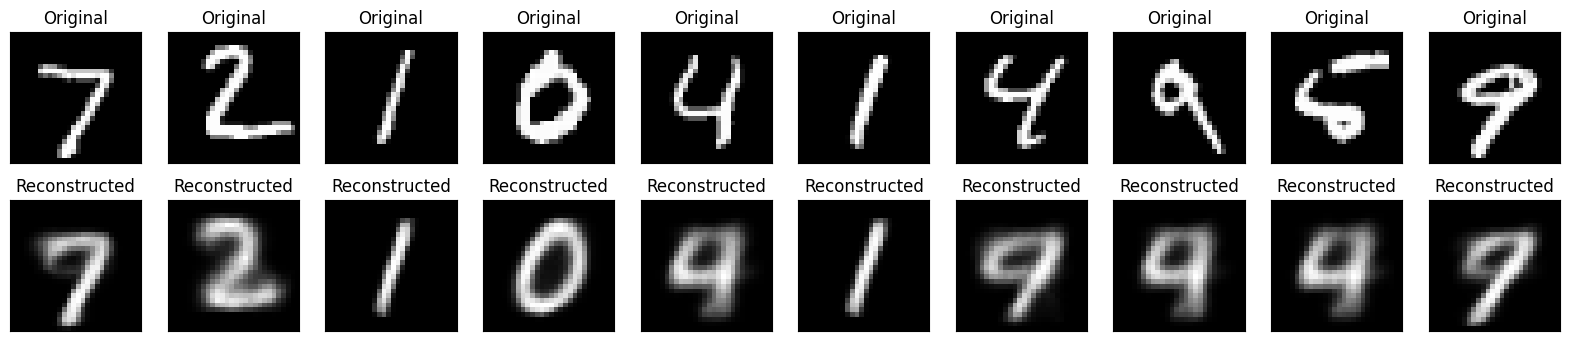

In [ ]:
# Get a batch of test images for reconstruction
dataiter = iter(test_loader)
images, _ = next(dataiter)

# Flatten and pass through the autoencoder
images_flat = images.view(images.size(0), -1)
with torch.no_grad():
    reconstructed = model(images_flat)

# Reshape back to image format
reconstructed_img = reconstructed.view(reconstructed.size(0), 1, 28, 28)

# Display original and reconstructed images
n = 10  # Number of digits to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Original")

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_img[i].squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Reconstructed")

plt.show()

The reconstructions won't be perfect—after all, we are compressing 784 dimensions of information into just 2\! But they are remarkably coherent, showing that the model captured the most essential features.

-----

## 3\. The Modern Connection: Vector Search and RAG

The fundamental idea of compressing complex data into a meaningful, low-dimensional vector (an **embedding**) is now a cornerstone of modern AI. The "code" our autoencoder learned is exactly this: an embedding.

### **Vector Search**

Once you have embeddings for your data, you can perform incredibly powerful semantic searches. The process is simple:

1.  **Index:** Use a trained encoder to convert every item in your database (images, products, songs, documents) into a vector embedding and store it in a specialized **vector database**.
2.  **Query:** When a user provides a query item (e.g., uploads an image), use the *same encoder* to convert the query into a vector.
3.  **Search:** Find the vectors in your database that are closest to the query vector using a similarity metric like **cosine similarity** or **Euclidean distance**.

This is the technology behind reverse image search, music recommendation ("find more songs like this"), and semantic document retrieval.

### **Retrieval-Augmented Generation (RAG)**

RAG is a technique that makes Large Language Models (LLMs) smarter by providing them with external, up-to-date information at query time. The "Retrieval" part of RAG is powered by vector search.

Here’s how it works:

1.  A knowledge base (e.g., a company's internal documents) is split into chunks.
2.  An encoder model converts each chunk into a vector embedding, which is stored in a vector database.
3.  When a user asks the LLM a question, the question is also converted into a vector.
4.  **Vector search** finds the most relevant document chunks from the database by comparing the question vector to the document vectors.
5.  These relevant chunks are passed to the LLM along with the original prompt. The LLM then uses this specific, targeted context to generate a highly accurate and factually-grounded answer.

The core principle that Hinton & Salakhutdinov demonstrated—that you can learn a rich, low-dimensional representation of complex data—is precisely what enables these advanced AI systems today.